## Underway fluorometer matchups for EN608

Compare underway fluorometer data with CTD cast data

### Step 1: parse underway data

In [1]:
import os

DIR = r'D:\nes-lter-ims-test-data\en608_underway'
assert os.path.exists(DIR)

In [2]:
import re
from io import StringIO
import pandas as pd

from neslter.parsing.ctd.hdr import HdrFile
from neslter.parsing.utils import clean_column_names

def doy2date(doy, origin='2017-12-31'):
    """convert decimal day of year to a datetime"""
    origin = pd.Timestamp(origin)
    return pd.to_datetime(doy, unit='D', origin=origin)

def read_cnv(path, doy_origin='2017-12-31'):
    assert os.path.exists(path)
    # skip header lines
    with open(path) as fin:
        lines = [l for l in fin.readlines() if not re.match('^[#*]', l)]
    txt = ''.join(lines)
    # read the space-delimited data
    # FIXME might actually be fixed-width
    df = pd.read_csv(StringIO(txt), delimiter='\s+', header=None)
    # hack to read the header data to get column names
    hdr = HdrFile(path, parse=False)
    hdr._read_lines()
    hdr._parse_names()
    df.columns = hdr.names
    df = clean_column_names(df)
    # convert dates from decimal day of year to proper datetimes
    df['date'] = doy2date(df.timej, origin=doy_origin)
    return df

# read and concatenate the two files for en608
df1 = read_cnv(os.path.join(DIR, '31Jan2018a.cnv'))
df2 = read_cnv(os.path.join(DIR, '01Feb2018a.cnv'))

df = pd.concat([df1, df2])
df.head()

,scan,timej,t090c,t190c,c0s_m,sal00,v0,wetstar,v1,fleco_afl,svcm,sigma_t00,latitude,longitude,flag,date
0,1,31.703507,3.3562,2.8892,2.970185,32.2545,0.1697,1.6175,0.0965,1.2599,1458.37,25.7032,41.28184,-71.07662,0.0,2018-01-31 16:53:03.004800
1,2,31.703576,3.3579,2.8921,2.970493,32.2564,0.1661,1.5615,0.0928,1.1647,1458.38,25.7045,41.28168,-71.07628,0.0,2018-01-31 16:53:08.966400
2,3,31.703646,3.3570,2.8889,2.970697,32.2598,0.1697,1.6175,0.0989,1.3234,1458.37,25.7075,41.28152,-71.07594,0.0,2018-01-31 16:53:15.014400
3,4,31.703715,3.3544,2.8906,2.971111,32.2673,0.1648,1.5428,0.0952,1.2282,1458.39,25.7134,41.28136,-71.07560,0.0,2018-01-31 16:53:20.976000
4,5,31.703785,3.3518,2.8941,2.970697,32.2650,0.1612,1.4867,0.0989,1.3234,1458.40,25.7112,41.28120,-71.07526,0.0,2018-01-31 16:53:27.024000


Winnow the underway data down to just the columns we need

In [3]:
uw = df[['date','wetstar','fleco_afl']].sort_values('date')
uw.head()

,date,wetstar,fleco_afl
0,2018-01-31 16:53:03.004800,1.6175,1.2599
1,2018-01-31 16:53:08.966400,1.5615,1.1647
2,2018-01-31 16:53:15.014400,1.6175,1.3234
3,2018-01-31 16:53:20.976000,1.5428,1.2282
4,2018-01-31 16:53:27.024000,1.4867,1.3234


### Step 2: compute surface fluorometer readings from bottle summary data

Read the bottle summary data from GitHub

In [4]:
BASE_URL = 'https://raw.githubusercontent.com/WHOIGit/nes-lter-examples/master/data/'

btl = pd.read_csv(BASE_URL + 'en608_btl.csv', index_col=0)

btl.date = pd.to_datetime(btl.date)
btl.sort_values('date').head()

,cruise,cast,niskin,date,sal00,sal11,sigma_t00,sigma_t11,oxsatmm_kg,sbox0mm_kg,...,v5,sbeox1v,v6,par,cpar,v7,spar,latitude,longitude,depsm
0,EN608,1,1,2018-01-31 19:34:26,32.3948,32.3924,25.8562,25.8542,335.05669,-89.479,...,0.0026,0.0026,0.9104,4.6488,0.19399,0.0,2396.5,41.19634,-70.87844,17.328561
1,EN608,1,2,2018-01-31 19:34:45,32.3940,32.3916,25.8559,25.8538,335.09742,-89.665,...,0.0024,0.0024,0.8910,4.3959,0.18340,0.0,2397.0,41.19634,-70.87844,17.480359
2,EN608,1,3,2018-01-31 19:34:54,32.3971,32.3946,25.8571,25.8551,334.95474,-89.521,...,0.0021,0.0021,0.8497,3.9022,0.16253,0.0,2401.0,41.19634,-70.87844,17.894084
3,EN608,1,4,2018-01-31 19:37:01,32.3840,32.3815,25.8514,25.8494,335.51519,-89.701,...,0.0019,0.0019,1.4852,20.3860,0.84595,0.0,2409.5,41.19636,-70.87832,12.473934
4,EN608,1,5,2018-01-31 19:37:05,32.3843,32.3820,25.8515,25.8496,335.50523,-89.668,...,0.0019,0.0019,1.5824,25.7460,1.07120,0.0,2404.9,41.19636,-70.87831,11.590901


Now for each cast, find the niskin with the minimum depth and compile those fluorometer readings into a dataset

In [5]:
sdf = btl[['cruise','cast','niskin','date','depsm','fleco_afl']]
sdf.index = range(len(sdf)) # need to reindex so groupby works
# group by cast and do an argmin operation to find the row with the minimum depth
ix = sdf.groupby(['cruise','cast']).apply(lambda a: a.depsm.idxmin())
# now select for just those rows
surf = sdf.loc[ix,:].sort_values('date')
surf

,cruise,cast,niskin,date,depsm,fleco_afl
31,EN608,1,13,2018-01-31 19:45:03,2.551007,1.4628
299,EN608,2,4,2018-02-01 00:38:04,3.918339,1.1376
9,EN608,3,4,2018-02-01 03:40:05,6.306614,2.1549
113,EN608,4,13,2018-02-01 05:52:30,3.461916,2.3406
135,EN608,5,20,2018-02-01 09:33:37,2.911272,1.7768
302,EN608,6,3,2018-02-01 13:56:43,4.912697,1.1825
13,EN608,7,4,2018-02-01 17:39:58,4.396726,0.9582
160,EN608,8,24,2018-02-01 19:31:59,4.947424,1.3769
179,EN608,9,18,2018-02-01 23:49:19,4.785763,1.2896
307,EN608,10,4,2018-02-02 04:10:43,5.495314,0.9937


### Step 3: merge underway and bottle summary surface data

Merge with underway data on nearest datetime, with a tolerance of 10s. This puts underway and bottle summary CTD data next to each other in the same table

In [6]:
# merge on closest datetime
merged = pd.merge_asof(surf, uw, on='date', direction='nearest', tolerance=pd.Timedelta('10s')).dropna()
# rename some columns to be a little clearer about what they mean
merged.columns = ['cruise','cast','niskin','date','depth','fleco_afl_ctd','wetstar_uw','fleco_afl_uw']
merged

,cruise,cast,niskin,date,depth,fleco_afl_ctd,wetstar_uw,fleco_afl_uw
0,EN608,1,13,2018-01-31 19:45:03,2.551007,1.4628,3.1120,2.1171
1,EN608,2,4,2018-02-01 00:38:04,3.918339,1.1376,1.4494,1.3869
2,EN608,3,4,2018-02-01 03:40:05,6.306614,2.1549,2.7757,3.0377
3,EN608,4,13,2018-02-01 05:52:30,3.461916,2.3406,2.4208,2.6885
4,EN608,5,20,2018-02-01 09:33:37,2.911272,1.7768,2.1032,2.1488
5,EN608,6,3,2018-02-01 13:56:43,4.912697,1.1825,1.7109,1.3552
6,EN608,7,4,2018-02-01 17:39:58,4.396726,0.9582,1.0010,0.9742
7,EN608,8,24,2018-02-01 19:31:59,4.947424,1.3769,1.2626,1.2282
8,EN608,9,18,2018-02-01 23:49:19,4.785763,1.2896,1.5988,1.7044
9,EN608,10,4,2018-02-02 04:10:43,5.495314,0.9937,1.2065,1.4822


### Step 4: get surface fluorometer readings from CTD downcasts

Read the CTD downcasts

In [7]:
BASE_URL = 'https://raw.githubusercontent.com/WHOIGit/nes-lter-examples/master/data/'

filename = 'en608_ctd_profiles.csv'

ddf = pd.read_csv(BASE_URL + filename)
ddf.head()

,scan,timej,times,prdm,t090c,t190c,t2_t190c,c0s_m,c1s_m,c2_c1s_m,...,potemp090c,potemp190c,svcm,svcm1,dz_dtm,gpa,nbin,flag,cruise,cast
0,1104,34.654491,45.943,10.077,11.9216,11.9249,0.0032,3.997355,3.997744,0.000393,...,11.9203,11.9236,1496.78,1496.79,0.354,0.073,69,0.0,EN608,18
1,1627,34.654743,67.750,11.085,11.9277,11.9282,0.0005,3.998145,3.998284,0.000083,...,11.9263,11.9268,1496.82,1496.82,0.446,0.116,56,0.0,EN608,18
2,1655,34.654755,68.910,12.093,11.9299,11.9306,0.0007,3.998432,3.998510,0.000071,...,11.9284,11.9291,1496.84,1496.84,0.617,0.129,37,0.0,EN608,18
3,1722,34.654789,71.717,13.101,11.9323,11.9322,-0.0001,3.998778,3.998760,-0.000015,...,11.9306,11.9305,1496.87,1496.87,0.283,0.143,78,0.0,EN608,18
4,1768,34.654812,73.623,14.108,11.9267,11.9285,0.0019,3.998163,3.998335,0.000224,...,11.9248,11.9267,1496.86,1496.87,0.674,0.158,34,0.0,EN608,18


Consider only data within a given depth range and then take the mean fluoremeter reading and treat as "surface" reading

In [8]:
MAX_DEPTH = 3
MIN_DEPTH = 6

sdf = ddf.copy()
# remove all rows except ones in the given depth range (inclusive)
sdf = sdf[(sdf.depsm >= MAX_DEPTH) & (sdf.depsm <= MIN_DEPTH)].sort_values('cast')
# take the mean per cast
sdf = sdf.groupby('cast').mean()

# convert dates and select only the columns we want
sdf['date'] = doy2date(sdf.timej)
sdf = sdf[['date','fleco_afl']]
sdf.head()

,date,fleco_afl
cast,,
1,2018-01-31 19:25:10.668000,2.196475
2,2018-02-01 00:28:59.728800,1.110875
4,2018-02-01 05:40:17.097600,2.218700
6,2018-02-01 13:47:49.891200,1.377300
7,2018-02-01 17:31:23.016000,1.085500


### Step 5: plot

In [9]:
# index downcast data by datetime
surf = sdf.copy()
surf.index = surf.pop('date')

# index merged uw/btl data by datetime
m = merged.copy()
m.index = m.pop('date')

# index underway data by datetime
s = uw.copy()
s.index = s.pop('date')

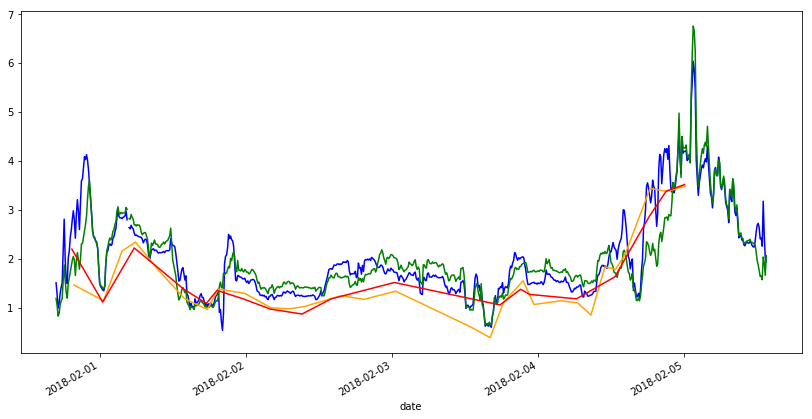

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(14,7))

# wetstar UW reading is blue
ax = s.wetstar.resample('10min').mean().plot(x_compat=True, c='blue')
# eco_afl UW reading is green
s.fleco_afl.resample('10min').mean().plot(ax=ax, c='green')
# bottle-summary-derived reading is in orange
m.fleco_afl_ctd.plot(ax=ax, c='orange')
# downcast-derived reading is in red
surf.fleco_afl.plot(ax=ax, c='red');